# League of Legends Champion Analysis

This notebook contains analyses of champion performance, winrates, and matchups from ranked solo matches.

**Player**: tattpåfersken (EUNE)  
**Period**: August 2024 - Present  
**Queue**: Ranked Solo/Duo (420)


## Directory

- [Data Collection](#data-collection) - How the match data was collected and processed
- [Champion Winrates (Zoe Games)](#champion-winrates-zoe-games) - Winrate with and against each champion in matches where you played Zoe
- [Luden's vs Shurelya's Comparison](#ludens-vs-shurelyas) - Performance comparison between two mythic items
- [Ionian Boots vs Crimson Lucidity](#ionian-boots-vs-crimson-lucidity) - Performance comparison between boots items (Feats of Strength completion)


---

## Champion Winrates (Zoe Games) {#champion-winrates-zoe-games}

Analyze winrates with teammates and against enemies for matches where you played Zoe.

**Questions:**
- Which champions do you win most with when playing Zoe?
- Which enemy champions do you struggle against when playing Zoe?
- Are there specific champion combinations that work well with Zoe?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the match data
df = pd.read_csv('../data/lol_matches.csv')

# Convert gameDate to datetime
df['gameDate'] = pd.to_datetime(df['gameDate'])

print(f"Total matches: {len(df)}")
print(f"Date range: {df['gameDate'].min().date()} to {df['gameDate'].max().date()}")
print(f"\nChampions played:")
print(df['championName'].value_counts())


Total matches: 299
Date range: 2025-04-26 to 2025-12-17

Champions played:
championName
Zoe           183
Bard           46
Zilean         19
Janna          14
Zyra            8
Xayah           7
Malphite        6
Morgana         4
Blitzcrank      4
Rakan           2
Thresh          2
Singed          1
Karma           1
Akali           1
Amumu           1
Name: count, dtype: int64


/tmp/ipykernel_18333/471670099.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['gameDate'] = pd.to_datetime(df['gameDate'])


In [9]:
# Filter to Zoe games only
zoe_games = df[df['championName'] == 'Zoe'].copy()

print(f"Total Zoe games: {len(zoe_games)}")
print(f"Zoe win rate: {(zoe_games['win'].mean() * 100):.1f}%")
print(f"Wins: {zoe_games['win'].sum()}, Losses: {(~zoe_games['win']).sum()}")

if len(zoe_games) == 0:
    print("\n⚠️  No Zoe games found in the dataset!")
else:
    zoe_games.head()


Total Zoe games: 183
Zoe win rate: 54.6%
Wins: 100, Losses: 83


### Load Full Match Data to Get Team Compositions

We need to load the full match data to see which champions were on your team and enemy team.


In [10]:
import json

# Load the raw match data
with open('../data/lol_matches_raw.json', 'r') as f:
    raw_matches = json.load(f)

# Create a mapping of matchId to full match data
match_dict = {match['metadata']['matchId']: match for match in raw_matches}

print(f"Loaded {len(match_dict)} matches from raw data")
print(f"Zoe game match IDs: {len(zoe_games)}")

# Get the match IDs for Zoe games
zoe_match_ids = set(zoe_games['matchId'].values)
print(f"Unique Zoe match IDs: {len(zoe_match_ids)}")


Loaded 299 matches from raw data
Zoe game match IDs: 183
Unique Zoe match IDs: 183


In [11]:
# Get PUUID from the first match (should be consistent)
# We'll get it from the Zoe games dataframe - need to find it in raw data
sample_match_id = zoe_games.iloc[0]['matchId']
sample_match = match_dict.get(sample_match_id)

if sample_match:
    # Find your PUUID from participants
    participants = sample_match['info']['participants']
    your_puuid = None
    for p in participants:
        if p['championName'] == 'Zoe':
            your_puuid = p['puuid']
            break
    
    print(f"Your PUUID: {your_puuid}")
else:
    print("Could not find sample match!")


Your PUUID: 3EqqeT7jqP2LDWpN-zjaAA7uiL66Mc_a3ecBtxMAUTkL_EvMp6oQVdDjE7bZBshSqhGomvYEijFC5w


In [12]:
# Analyze winrates with teammates and against enemies for Zoe games
champions_with = defaultdict(lambda: {'wins': 0, 'games': 0})
champions_against = defaultdict(lambda: {'wins': 0, 'games': 0})

for match_id in zoe_match_ids:
    match_data = match_dict.get(match_id)
    if not match_data:
        continue
    
    # Get match result (win/loss)
    info = match_data['info']
    participants = info['participants']
    
    # Find your team ID
    your_team_id = None
    match_result = None  # True = win, False = loss
    
    for p in participants:
        if p['puuid'] == your_puuid:
            your_team_id = p['teamId']
            match_result = p['win']
            break
    
    if your_team_id is None:
        continue
    
    # Analyze teammates (same team, different champion)
    for p in participants:
        if p['puuid'] == your_puuid:
            continue  # Skip yourself
        
        champ_name = p['championName']
        
        if p['teamId'] == your_team_id:
            # Teammate
            champions_with[champ_name]['games'] += 1
            if match_result:
                champions_with[champ_name]['wins'] += 1
        else:
            # Enemy
            champions_against[champ_name]['games'] += 1
            if match_result:
                champions_against[champ_name]['wins'] += 1

print(f"Processed {len(zoe_match_ids)} Zoe matches")
print(f"Found {len(champions_with)} unique teammate champions")
print(f"Found {len(champions_against)} unique enemy champions")


Processed 183 Zoe matches
Found 141 unique teammate champions
Found 164 unique enemy champions


In [13]:
# Calculate winrates and create DataFrames
def create_winrate_df(champ_dict, title_prefix):
    data = []
    for champ, stats in champ_dict.items():
        winrate = (stats['wins'] / stats['games'] * 100) if stats['games'] > 0 else 0
        data.append({
            'Champion': champ,
            'Games': stats['games'],
            'Wins': stats['wins'],
            'Losses': stats['games'] - stats['wins'],
            'Winrate': winrate
        })
    
    df_result = pd.DataFrame(data)
    df_result = df_result.sort_values('Games', ascending=False)
    return df_result

# Create DataFrames
teammates_df = create_winrate_df(champions_with, 'With')
enemies_df = create_winrate_df(champions_against, 'Against')

print("=" * 60)
print("WINRATES WITH TEAMMATES (When playing Zoe)")
print("=" * 60)
print(teammates_df.to_string(index=False))

print("\n" + "=" * 60)
print("WINRATES AGAINST ENEMIES (When playing Zoe)")
print("=" * 60)
print(enemies_df.to_string(index=False))


WINRATES WITH TEAMMATES (When playing Zoe)
    Champion  Games  Wins  Losses    Winrate
     Smolder     25    15      10  60.000000
     Caitlyn     23    12      11  52.173913
      Khazix     19    13       6  68.421053
        Jhin     19    10       9  52.631579
       Diana     15     7       8  46.666667
       Yasuo     14     9       5  64.285714
         Zed     14     8       6  57.142857
      Darius     13     6       7  46.153846
       Kaisa     12     5       7  41.666667
        Jinx     12     8       4  66.666667
        Yone     11     9       2  81.818182
 MissFortune     11     9       2  81.818182
       Sivir     11     6       5  54.545455
         Mel     10     7       3  70.000000
    JarvanIV     10     5       5  50.000000
      Ezreal     10     4       6  40.000000
    Katarina     10     5       5  50.000000
      Qiyana      9     5       4  55.555556
    MasterYi      9     5       4  55.555556
         Lux      9     4       5  44.444444
      LeeSin

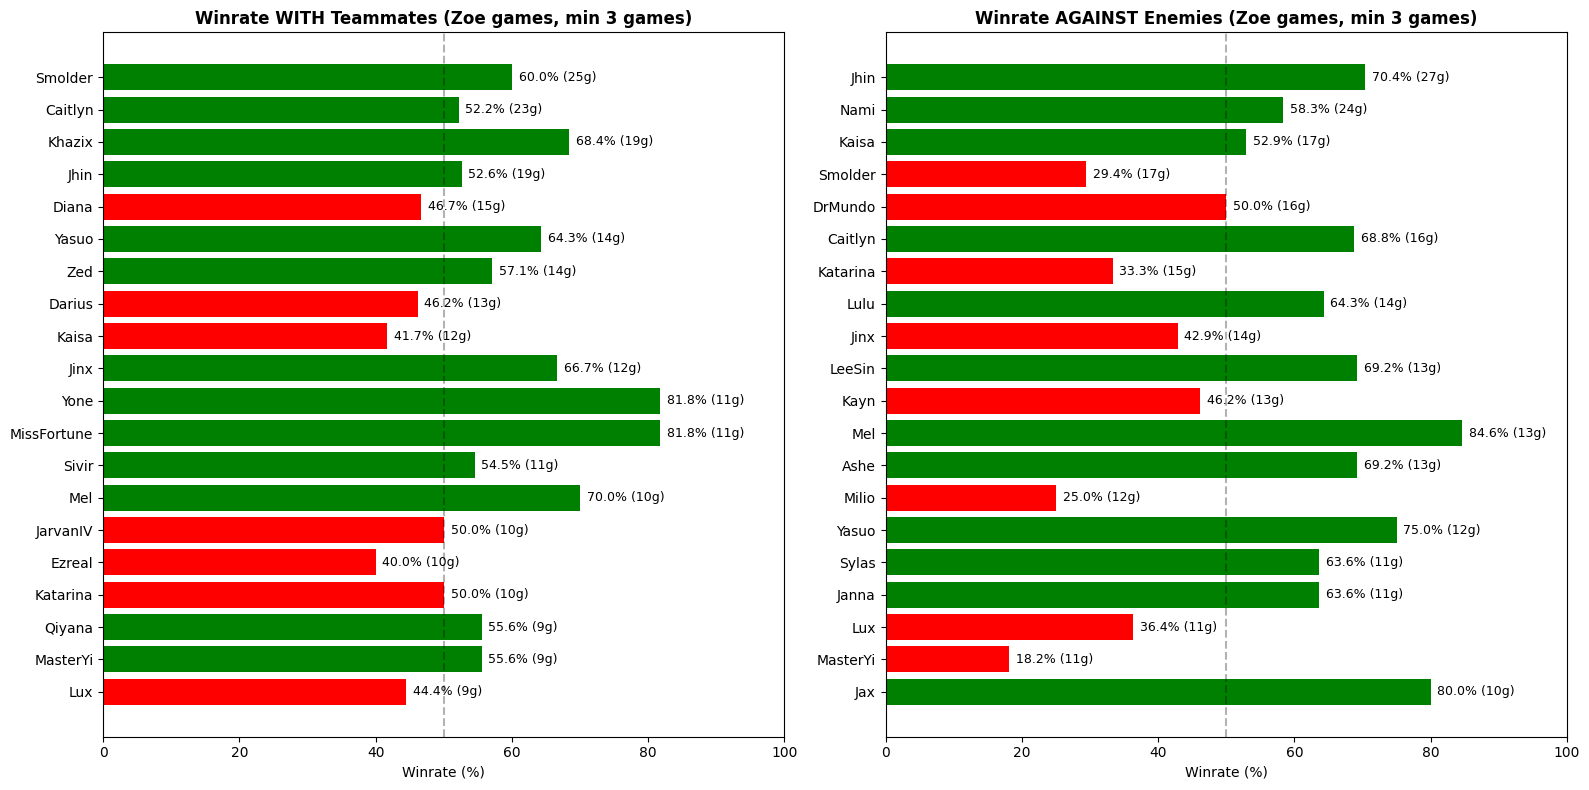


Note: Only showing champions with at least 3 games for statistical significance


In [14]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Filter to champions with at least 3 games for better statistical significance
min_games = 3

# Teammates
teammates_filtered = teammates_df[teammates_df['Games'] >= min_games].head(20)
ax1 = axes[0]
bars1 = ax1.barh(range(len(teammates_filtered)), teammates_filtered['Winrate'], 
                 color=['green' if w > 50 else 'red' for w in teammates_filtered['Winrate']])
ax1.set_yticks(range(len(teammates_filtered)))
ax1.set_yticklabels(teammates_filtered['Champion'])
ax1.set_xlabel('Winrate (%)')
ax1.set_title(f'Winrate WITH Teammates (Zoe games, min {min_games} games)', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='black', linestyle='--', alpha=0.3)
ax1.set_xlim(0, 100)
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(teammates_filtered.iterrows()):
    ax1.text(row['Winrate'] + 1, i, f"{row['Winrate']:.1f}% ({row['Games']}g)", 
             va='center', fontsize=9)

# Enemies
enemies_filtered = enemies_df[enemies_df['Games'] >= min_games].head(20)
ax2 = axes[1]
bars2 = ax2.barh(range(len(enemies_filtered)), enemies_filtered['Winrate'],
                 color=['green' if w > 50 else 'red' for w in enemies_filtered['Winrate']])
ax2.set_yticks(range(len(enemies_filtered)))
ax2.set_yticklabels(enemies_filtered['Champion'])
ax2.set_xlabel('Winrate (%)')
ax2.set_title(f'Winrate AGAINST Enemies (Zoe games, min {min_games} games)', fontsize=12, fontweight='bold')
ax2.axvline(x=50, color='black', linestyle='--', alpha=0.3)
ax2.set_xlim(0, 100)
ax2.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(enemies_filtered.iterrows()):
    ax2.text(row['Winrate'] + 1, i, f"{row['Winrate']:.1f}% ({row['Games']}g)", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nNote: Only showing champions with at least {min_games} games for statistical significance")


---

## Luden's vs Shurelya's Comparison {#ludens-vs-shurelyas}

Compare performance metrics between games where you built Luden's Companion vs Shurelya's Battlesong.

**Questions:**
- Which item has a higher winrate?
- How does damage output differ?
- Are there differences in deaths, KDA, or other stats?
- When is each item more effective?


In [15]:
# Setup: Filter Zoe games by item and create statistical comparison
if 'pd' not in locals() and 'pd' not in globals():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

if 'zoe_games' not in locals() and 'zoe_games' not in globals():
    if 'df' not in locals() and 'df' not in globals():
        df = pd.read_csv('../data/lol_matches.csv')
        df['gameDate'] = pd.to_datetime(df['gameDate'])
    zoe_games = df[df['championName'] == 'Zoe'].copy()

# Item IDs: Luden's Companion = 6655, Shurelya's Battlesong = 2065
LUDENS_ITEM_ID = 6655
SHURELYAS_ITEM_ID = 2065

# Filter Zoe games by item
def get_mythic_item(row):
    for i in range(7):
        item_id = row.get(f'item{i}', 0)
        if item_id == LUDENS_ITEM_ID:
            return 'Ludens'
        elif item_id == SHURELYAS_ITEM_ID:
            return 'Shurelyas'
    return None

zoe_games_with_items = zoe_games.copy()
zoe_games_with_items['mythic_item'] = zoe_games_with_items.apply(get_mythic_item, axis=1)
ludens_shurelyas_games = zoe_games_with_items[zoe_games_with_items['mythic_item'].notna()].copy()

ludens_games = ludens_shurelyas_games[ludens_shurelyas_games['mythic_item'] == 'Ludens']
shurelyas_games = ludens_shurelyas_games[ludens_shurelyas_games['mythic_item'] == 'Shurelyas']

# Statistical comparison table
comparison_stats = ['win', 'kills', 'deaths', 'assists', 'kda', 
                    'totalDamageDealtToChampions', 'damagePerMin',
                    'goldEarned', 'goldPerMin', 'csPerMin', 
                    'visionScore', 'visionScorePerMin', 'killParticipation']

comparison_data = []
for stat in comparison_stats:
    ludens_mean = ludens_games[stat].mean()
    shurelyas_mean = shurelyas_games[stat].mean()
    difference = ludens_mean - shurelyas_mean
    pct_diff = (difference / shurelyas_mean * 100) if shurelyas_mean != 0 else 0
    
    comparison_data.append({
        'Stat': stat,
        'Ludens': round(ludens_mean, 2),
        'Shurelyas': round(shurelyas_mean, 2),
        'Difference': round(difference, 2),
        '% Difference': round(pct_diff, 1)
    })

comparison_table = pd.DataFrame(comparison_data)

print("=" * 70)
print("STATISTICAL COMPARISON: LUDEN'S vs SHURELYA'S")
print("=" * 70)
print(comparison_table.to_string(index=False))
print(f"\nSample sizes: Luden's: {len(ludens_games)} games | Shurelya's: {len(shurelyas_games)} games")


STATISTICAL COMPARISON: LUDEN'S vs SHURELYA'S
                       Stat   Ludens  Shurelyas  Difference  % Difference
                        win     0.56       0.55        0.02           3.0
                      kills     3.88       3.97       -0.09          -2.3
                     deaths     5.60       5.78       -0.18          -3.1
                    assists    11.56      13.53       -1.97         -14.5
                        kda     4.09       4.68       -0.59         -12.6
totalDamageDealtToChampions 21381.88   20983.51      398.36           1.9
               damagePerMin   708.27     655.52       52.75           8.0
                 goldEarned  9650.40   10063.70     -413.30          -4.1
                 goldPerMin   325.17     320.98        4.19           1.3
                   csPerMin     1.51       1.41        0.10           7.3
                visionScore    58.85      70.22      -11.36         -16.2
          visionScorePerMin     1.96       2.23       -0.27       

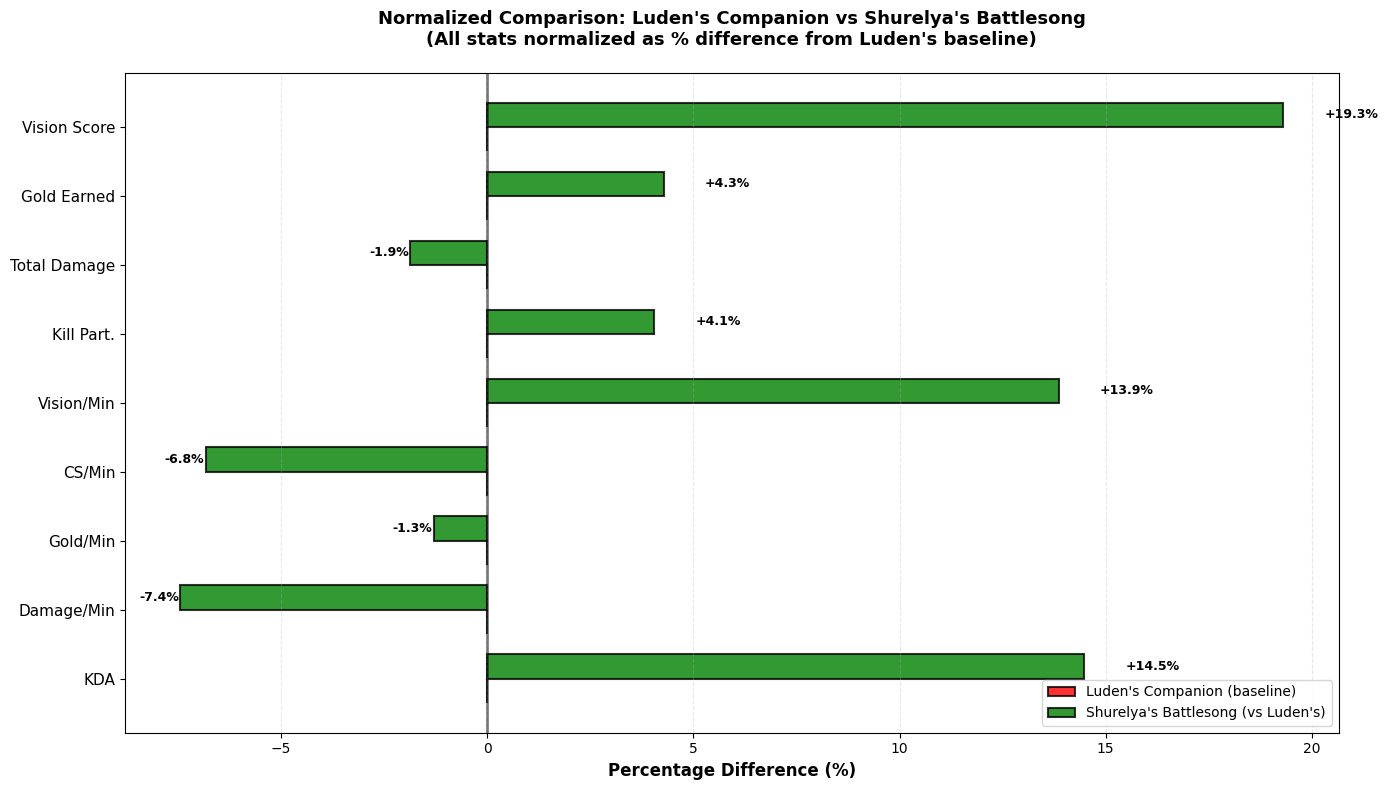

In [16]:
# Normalized percentage comparison chart
comparison_stats_normalized = {
    'KDA': 'kda',
    'Damage/Min': 'damagePerMin',
    'Gold/Min': 'goldPerMin',
    'CS/Min': 'csPerMin',
    'Vision/Min': 'visionScorePerMin',
    'Kill Part.': 'killParticipation',
    'Total Damage': 'totalDamageDealtToChampions',
    'Gold Earned': 'goldEarned',
    'Vision Score': 'visionScore'
}

# Calculate percentage differences (Shurelya's relative to Luden's)
normalized_data = []
for label, stat in comparison_stats_normalized.items():
    ludens_val = ludens_games[stat].mean()
    shurelyas_val = shurelyas_games[stat].mean()
    
    if ludens_val != 0:
        pct_diff = ((shurelyas_val - ludens_val) / ludens_val) * 100
    else:
        pct_diff = 0
    
    normalized_data.append({
        'Stat': label,
        'Luden\'s %': 0,  # Baseline at 0%
        'Shurelya\'s %': pct_diff
    })

normalized_df = pd.DataFrame(normalized_data)

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(normalized_df))
width = 0.35

# Create bars - Luden's at baseline (0), Shurelya's as percentage difference
# Red for Luden's, Green for Shurelya's
ludens_values = normalized_df['Luden\'s %'].values
shurelyas_values = normalized_df['Shurelya\'s %'].values

# Create bars with explicit colors
bars1 = ax.barh(x - width/2, ludens_values, width, 
                label='Luden\'s Companion (baseline)', 
                color='red', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.barh(x + width/2, shurelyas_values, width,
                label='Shurelya\'s Battlesong (vs Luden\'s)', 
                color='green', alpha=0.8, edgecolor='black', linewidth=1.5)

# Force set colors explicitly using facecolor (more reliable than color)
for i, bar in enumerate(bars1):
    bar.set_facecolor('red')
    bar.set_edgecolor('black')
for i, bar in enumerate(bars2):
    bar.set_facecolor('green')
    bar.set_edgecolor('black')

# Add value labels on bars
for i, (idx, row) in enumerate(normalized_df.iterrows()):
    shurelyas_pct = row['Shurelya\'s %']
    ax.text(0 + (1 if 0 > 0 else -1), i - width/2,
            '0.0%', va='center', fontweight='bold', fontsize=9, color='white')
    if abs(shurelyas_pct) > 1:
        ax.text(shurelyas_pct + (1 if shurelyas_pct > 0 else -1), i + width/2, 
                f'{shurelyas_pct:+.1f}%', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Percentage Difference (%)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Comparison: Luden\'s Companion vs Shurelya\'s Battlesong\n(All stats normalized as % difference from Luden\'s baseline)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_yticks(x)
ax.set_yticklabels(normalized_df['Stat'], fontsize=11)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


---

## Ionian Boots vs Crimson Lucidity {#ionian-boots-vs-crimson-lucidity}

Compare performance metrics between games where you ended with Ionian Boots of Lucidity vs Crimson Lucidity (Feats of Strength completion).

**Questions:**
- Which boots item has a higher winrate?
- How does damage output differ?
- Are there differences in deaths, KDA, or other stats?
- When is each item more effective?


In [17]:
# Setup: Filter Zoe games by item and create statistical comparison
if 'pd' not in locals() and 'pd' not in globals():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

if 'zoe_games' not in locals() and 'zoe_games' not in globals():
    if 'df' not in locals() and 'df' not in globals():
        df = pd.read_csv('../data/lol_matches.csv')
        df['gameDate'] = pd.to_datetime(df['gameDate'])
    zoe_games = df[df['championName'] == 'Zoe'].copy()

# Item IDs: Ionian Boots of Lucidity = 3158, Crimson Lucidity = 6690
IONIAN_BOOTS_ITEM_ID = 3158
CRIMSON_LUCIDITY_ITEM_ID = 3171

# Filter Zoe games by item
def get_boots_item(row):
    for i in range(7):
        item_id = row.get(f'item{i}', 0)
        if item_id == IONIAN_BOOTS_ITEM_ID:
            return 'Ionian Boots'
        elif item_id == CRIMSON_LUCIDITY_ITEM_ID:
            return 'Crimson Lucidity'
    return None

zoe_games_with_boots = zoe_games.copy()
zoe_games_with_boots['boots_item'] = zoe_games_with_boots.apply(get_boots_item, axis=1)
ionian_crimson_games = zoe_games_with_boots[zoe_games_with_boots['boots_item'].notna()].copy()

ionian_boots_games = ionian_crimson_games[ionian_crimson_games['boots_item'] == 'Ionian Boots']
crimson_lucidity_games = ionian_crimson_games[ionian_crimson_games['boots_item'] == 'Crimson Lucidity']

# Statistical comparison table
comparison_stats = ['win', 'kills', 'deaths', 'assists', 'kda', 
                    'totalDamageDealtToChampions', 'damagePerMin',
                    'goldEarned', 'goldPerMin', 'csPerMin', 
                    'visionScore', 'visionScorePerMin', 'killParticipation']

comparison_data = []

# Add Winrate row first (as percentage)
ionian_winrate = ionian_boots_games['win'].mean() * 100
crimson_winrate = crimson_lucidity_games['win'].mean() * 100
winrate_diff = ionian_winrate - crimson_winrate
winrate_pct_diff = (winrate_diff / crimson_winrate * 100) if crimson_winrate != 0 else 0

comparison_data.append({
    'Stat': 'Winrate (%)',
    'Ionian Boots': round(ionian_winrate, 1),
    'Crimson Lucidity': round(crimson_winrate, 1),
    'Difference': round(winrate_diff, 1),
    '% Difference': round(winrate_pct_diff, 1)
})

# Add other stats
for stat in comparison_stats:
    ionian_mean = ionian_boots_games[stat].mean()
    crimson_mean = crimson_lucidity_games[stat].mean()
    difference = ionian_mean - crimson_mean
    pct_diff = (difference / crimson_mean * 100) if crimson_mean != 0 else 0
    
    comparison_data.append({
        'Stat': stat,
        'Ionian Boots': round(ionian_mean, 2),
        'Crimson Lucidity': round(crimson_mean, 2),
        'Difference': round(difference, 2),
        '% Difference': round(pct_diff, 1)
    })

comparison_table = pd.DataFrame(comparison_data)

print("=" * 70)
print("STATISTICAL COMPARISON: IONIAN BOOTS vs CRIMSON LUCIDITY")
print("=" * 70)
print(comparison_table.to_string(index=False))
print(f"\nSample sizes: Ionian Boots: {len(ionian_boots_games)} games | Crimson Lucidity: {len(crimson_lucidity_games)} games")


STATISTICAL COMPARISON: IONIAN BOOTS vs CRIMSON LUCIDITY
                       Stat  Ionian Boots  Crimson Lucidity  Difference  % Difference
                Winrate (%)         33.30             75.60      -42.30         -55.9
                        win          0.33              0.76       -0.42         -55.9
                      kills          3.38              4.10       -0.71         -17.4
                     deaths          6.22              5.20        1.02          19.7
                    assists         11.05             14.48       -3.42         -23.7
                        kda          3.26              5.00       -1.74         -34.8
totalDamageDealtToChampions      19164.33          21895.51    -2731.18         -12.5
               damagePerMin        617.54            684.90      -67.36          -9.8
                 goldEarned       9291.21          10371.62    -1080.42         -10.4
                 goldPerMin        304.61            332.27      -27.66          -8

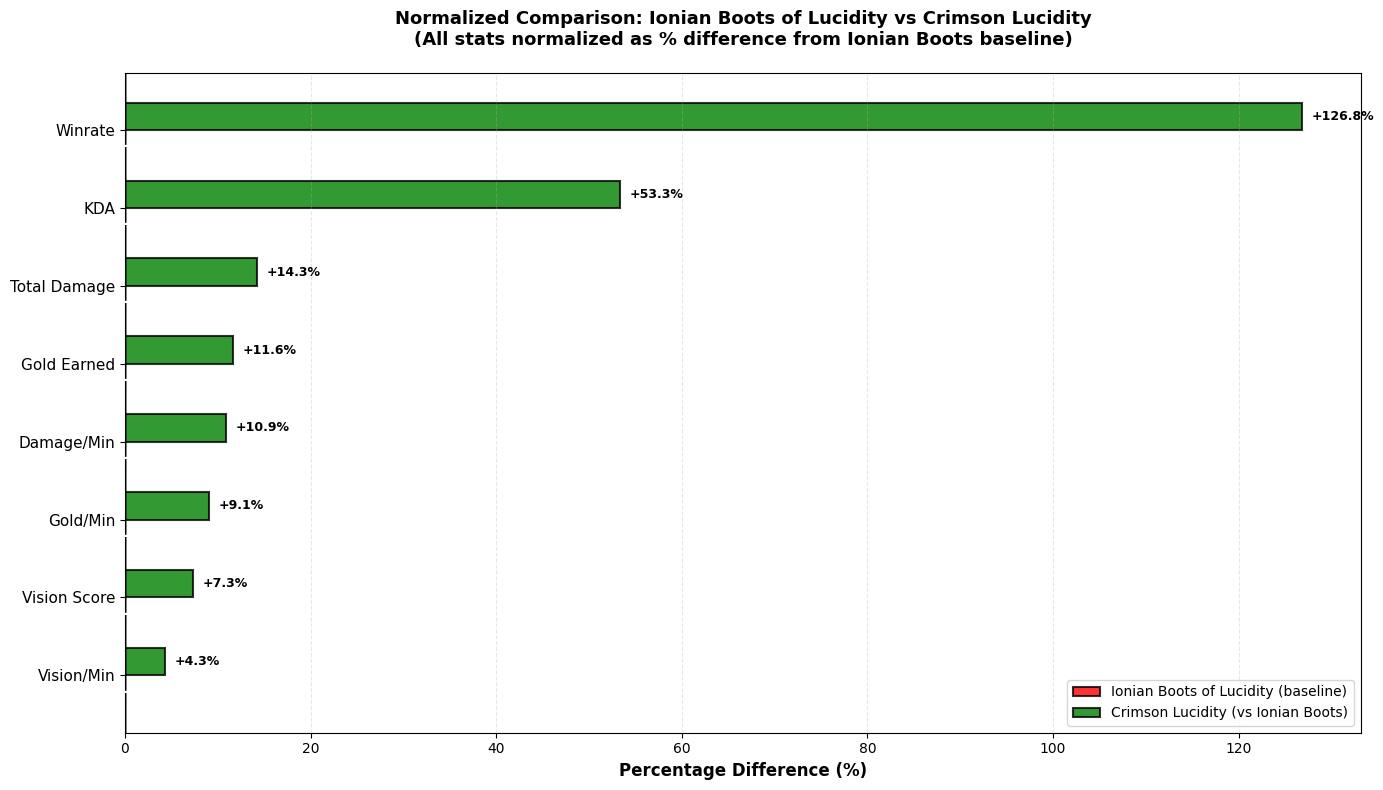

In [18]:
# Normalized percentage comparison chart
comparison_stats_normalized = {
    'Winrate': 'win',
    'KDA': 'kda',
    'Damage/Min': 'damagePerMin',
    'Gold/Min': 'goldPerMin',
    'Vision/Min': 'visionScorePerMin',
    'Total Damage': 'totalDamageDealtToChampions',
    'Gold Earned': 'goldEarned',
    'Vision Score': 'visionScore'
}

# Calculate percentage differences (Crimson Lucidity relative to Ionian Boots)
normalized_data = []
for label, stat in comparison_stats_normalized.items():
    ionian_val = ionian_boots_games[stat].mean()
    crimson_val = crimson_lucidity_games[stat].mean()
    
    # For winrate, convert to percentage for display
    if stat == 'win':
        ionian_val = ionian_val * 100
        crimson_val = crimson_val * 100
    
    if ionian_val != 0:
        pct_diff = ((crimson_val - ionian_val) / ionian_val) * 100
    else:
        pct_diff = 0
    
    normalized_data.append({
        'Stat': label,
        'Ionian Boots %': 0,  # Baseline at 0%
        'Crimson Lucidity %': pct_diff
    })

normalized_df = pd.DataFrame(normalized_data)

# Sort by absolute percentage difference (biggest difference at top)
# Sort ascending so biggest appears at top (barh displays first row at bottom)
normalized_df['abs_diff'] = normalized_df['Crimson Lucidity %'].abs()
normalized_df = normalized_df.sort_values('abs_diff', ascending=True).drop('abs_diff', axis=1)

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(normalized_df))
width = 0.35

# Create bars - Ionian Boots at baseline (0), Crimson Lucidity as percentage difference
# Red for Ionian Boots, Green for Crimson Lucidity
ionian_values = normalized_df['Ionian Boots %'].values
crimson_values = normalized_df['Crimson Lucidity %'].values

# Create bars with explicit colors
bars1 = ax.barh(x - width/2, ionian_values, width, 
                label='Ionian Boots of Lucidity (baseline)', 
                color='red', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.barh(x + width/2, crimson_values, width,
                label='Crimson Lucidity (vs Ionian Boots)', 
                color='green', alpha=0.8, edgecolor='black', linewidth=1.5)

# Force set colors explicitly using facecolor (more reliable than color)
for i, bar in enumerate(bars1):
    bar.set_facecolor('red')
    bar.set_edgecolor('black')
for i, bar in enumerate(bars2):
    bar.set_facecolor('green')
    bar.set_edgecolor('black')

# Add value labels on bars
for i, (idx, row) in enumerate(normalized_df.iterrows()):
    crimson_pct = row['Crimson Lucidity %']
    ax.text(0 + (1 if 0 > 0 else -1), i - width/2,
            '0.0%', va='center', fontweight='bold', fontsize=9, color='white')
    if abs(crimson_pct) > 1:
        ax.text(crimson_pct + (1 if crimson_pct > 0 else -1), i + width/2, 
                f'{crimson_pct:+.1f}%', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Percentage Difference (%)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Comparison: Ionian Boots of Lucidity vs Crimson Lucidity\n(All stats normalized as % difference from Ionian Boots baseline)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_yticks(x)
ax.set_yticklabels(normalized_df['Stat'], fontsize=11)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


---
?
## Atakhan Impact Analysis {#atakhan-impact-analysis}

Analyze the impact of killing Atakhan (neutral objective) on game outcomes.

**Questions:**
- What's the winrate when your team kills Atakhan vs when they don't?
- How impactful is securing Atakhan for winning games?


In [19]:
# Setup: Analyze Atakhan impact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load data
df = pd.read_csv('../data/lol_matches.csv')
df['gameDate'] = pd.to_datetime(df['gameDate'])

# Load raw match data
print("Loading match data...")
with open('../data/lol_matches_raw.json', 'r') as f:
    raw_matches = json.load(f)
match_dict = {match['metadata']['matchId']: match for match in raw_matches}
print(f"Loaded {len(match_dict)} matches")

# Analyze Atakhan kills and win/loss
print("Analyzing Atakhan data...")
atakhan_data = []

for idx, row in df.iterrows():
    match_id = row['matchId']
    match_data = match_dict.get(match_id)
    
    if not match_data:
        continue
    
    # Find your team ID
    your_team_id = row['teamId']
    match_result = row['win']
    
    # Get Atakhan kills for your team
    teams = match_data['info']['teams']
    your_team_atakhan_kills = 0
    
    for team in teams:
        if team['teamId'] == your_team_id:
            your_team_atakhan_kills = team.get('objectives', {}).get('atakhan', {}).get('kills', 0)
            break
    
    atakhan_data.append({
        'matchId': match_id,
        'win': match_result,
        'atakhan_killed': your_team_atakhan_kills > 0,
        'atakhan_kills': your_team_atakhan_kills
    })

atakhan_df = pd.DataFrame(atakhan_data)

# Create 2x2 contingency table
contingency = pd.crosstab(
    atakhan_df['atakhan_killed'], 
    atakhan_df['win'], 
    margins=True
)

print("=" * 70)
print("ATAKHAN IMPACT ANALYSIS")
print("=" * 70)
print("\n2x2 Contingency Table:")
print(contingency)
print()

# Calculate winrates
atakhan_killed_winrate = atakhan_df[atakhan_df['atakhan_killed'] == True]['win'].mean() * 100
atakhan_not_killed_winrate = atakhan_df[atakhan_df['atakhan_killed'] == False]['win'].mean() * 100

atakhan_killed_count = len(atakhan_df[atakhan_df['atakhan_killed'] == True])
atakhan_not_killed_count = len(atakhan_df[atakhan_df['atakhan_killed'] == False])

print(f"\nWinrate when team killed Atakhan: {atakhan_killed_winrate:.1f}% ({atakhan_killed_count} games)")
print(f"Winrate when team did NOT kill Atakhan: {atakhan_not_killed_winrate:.1f}% ({atakhan_not_killed_count} games)")
print(f"\nDifference: {atakhan_killed_winrate - atakhan_not_killed_winrate:.1f} percentage points")


/tmp/ipykernel_18333/578047985.py:9: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['gameDate'] = pd.to_datetime(df['gameDate'])


Loading match data...
Loaded 299 matches
Analyzing Atakhan data...
ATAKHAN IMPACT ANALYSIS

2x2 Contingency Table:
win             False  True  All
atakhan_killed                  
False             112    52  164
True               28   107  135
All               140   159  299


Winrate when team killed Atakhan: 79.3% (135 games)
Winrate when team did NOT kill Atakhan: 31.7% (164 games)

Difference: 47.6 percentage points


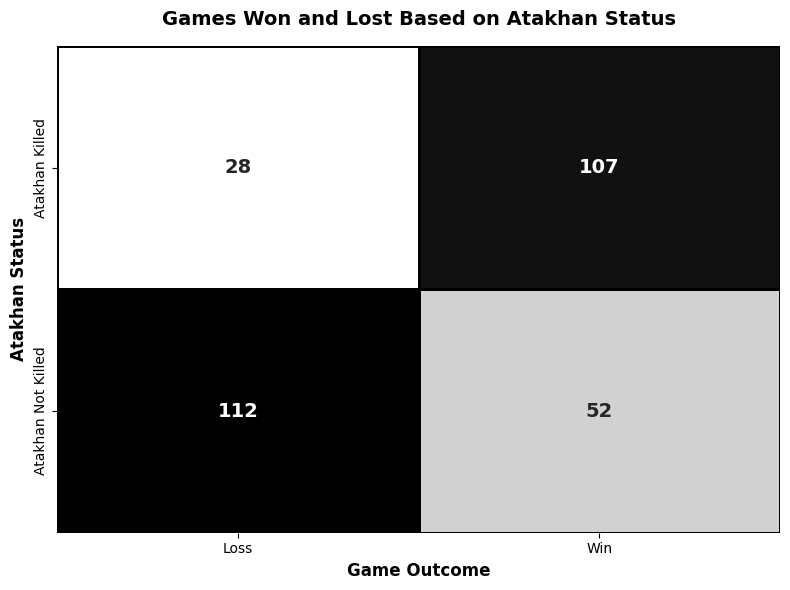


Summary:
  Games where team killed Atakhan: 135 (79.3% winrate)
  Games where team did NOT kill Atakhan: 164 (31.7% winrate)
  Difference: 47.6 percentage points


In [20]:
# Create 2x2 contingency table visualization
import seaborn as sns

# Prepare data for contingency table (Loss first, Win second - so Loss is on left)
table_data = pd.crosstab(
    atakhan_df['atakhan_killed'].map({True: 'Atakhan Killed', False: 'Atakhan Not Killed'}),
    atakhan_df['win'].map({True: 'Win', False: 'Loss'}),
    margins=False
)

# Reorder columns: Loss first (left), Win second (right)
table_data = table_data[['Loss', 'Win']]

# Calculate winrates for summary
atakhan_killed_total = table_data.loc['Atakhan Killed', 'Win'] + table_data.loc['Atakhan Killed', 'Loss']
atakhan_not_killed_total = table_data.loc['Atakhan Not Killed', 'Win'] + table_data.loc['Atakhan Not Killed', 'Loss']
atakhan_killed_wr = (table_data.loc['Atakhan Killed', 'Win'] / atakhan_killed_total * 100) if atakhan_killed_total > 0 else 0
atakhan_not_killed_wr = (table_data.loc['Atakhan Not Killed', 'Win'] / atakhan_not_killed_total * 100) if atakhan_not_killed_total > 0 else 0

# Create contingency table heatmap
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap first - we'll override colors manually, so use a neutral colormap
sns.heatmap(table_data, annot=True, fmt='d', 
            linewidths=2, linecolor='black', ax=ax, 
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar=False,
            cmap='Greys',
            vmin=table_data.min().min(),
            vmax=table_data.max().max())

# Get values for each cell
ak_loss = table_data.loc['Atakhan Killed', 'Loss']
ak_win = table_data.loc['Atakhan Killed', 'Win']
ank_loss = table_data.loc['Atakhan Not Killed', 'Loss']
ank_win = table_data.loc['Atakhan Not Killed', 'Win']

# Normalize ALL values across the entire table for grayscale
# White (1.0, 1.0, 1.0) for lowest value, Black (0.0, 0.0, 0.0) for highest value
all_values = [ak_loss, ak_win, ank_loss, ank_win]
value_min = min(all_values)
value_max = max(all_values)
value_range = value_max - value_min if value_max > value_min else 1

# Calculate grayscale colors (0 = white, 1 = black)
def get_grayscale(value):
    if value_range > 0:
        intensity = (value - value_min) / value_range  # 0 to 1, where 0 = min, 1 = max
        gray = 1.0 - intensity  # Invert: 0 = black, 1 = white
        return (gray, gray, gray)
    else:
        return (0.5, 0.5, 0.5)  # Medium gray if all values are the same

ak_loss_color = get_grayscale(ak_loss)
ak_win_color = get_grayscale(ak_win)
ank_loss_color = get_grayscale(ank_loss)
ank_win_color = get_grayscale(ank_win)

# Manually set colors for each cell
# Patches are created in row-major order: row 0 (Atakhan Killed) then row 1 (Atakhan Not Killed)
# Within each row: Loss (col 0, left) then Win (col 1, right)
# So order is: [0] Atakhan Killed-Loss, [1] Atakhan Killed-Win, [2] Atakhan Not Killed-Loss, [3] Atakhan Not Killed-Win

# Filter to only get rectangle patches (heatmap cells)
rect_patches = [p for p in ax.patches if hasattr(p, 'get_width') and p.get_width() > 0 and p.get_height() > 0]

# Set colors explicitly - use set_facecolor and also set_color to ensure it sticks
if len(rect_patches) >= 4:
    colors = [ak_loss_color, ak_win_color, ank_loss_color, ank_win_color]
    for i, patch in enumerate(rect_patches[:4]):
        patch.set_facecolor(colors[i])
        patch.set_color(colors[i])  # Also set color property
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
    
    # Debug: print colors to verify they're grayscale
    print(f"Colors being applied: {colors}")

ax.set_title('Games Won and Lost Based on Atakhan Status', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Game Outcome', fontsize=12, fontweight='bold')
ax.set_ylabel('Atakhan Status', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Games where team killed Atakhan: {atakhan_killed_total} ({atakhan_killed_wr:.1f}% winrate)")
print(f"  Games where team did NOT kill Atakhan: {atakhan_not_killed_total} ({atakhan_not_killed_wr:.1f}% winrate)")
print(f"  Difference: {atakhan_killed_wr - atakhan_not_killed_wr:.1f} percentage points")


## Reflection
It seems that on most "carry" damage characters, I have great winrates. I do horrible against characters with surprisingly low cc, and well against characters with good cc.